# Normalization

Этапы:
* Background correction (Первичная отчистака данных от мусора и шумов)
* Normalization (Нормализация экспресии генов) 
* Summarization (Преобразование в статистические величины) 

https://math.usu.edu/jrstevens/stat5570/1.4.preprocess_4up.pdf

In [ ]:
# Установка пакетов oligo, oligoData
# Можно этот пункт пропустить, если у Вас пакеты
# oligo и oligoData установлены
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("oligo")
BiocManager::install("oligoData")

In [1]:
# Загружаем библиотеки
library("oligo")
library("oligoData")
data(affyExpressionFS)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: oligoClasses

Welcome to oligoClasses version 1.50.0

Loading required package: Bi

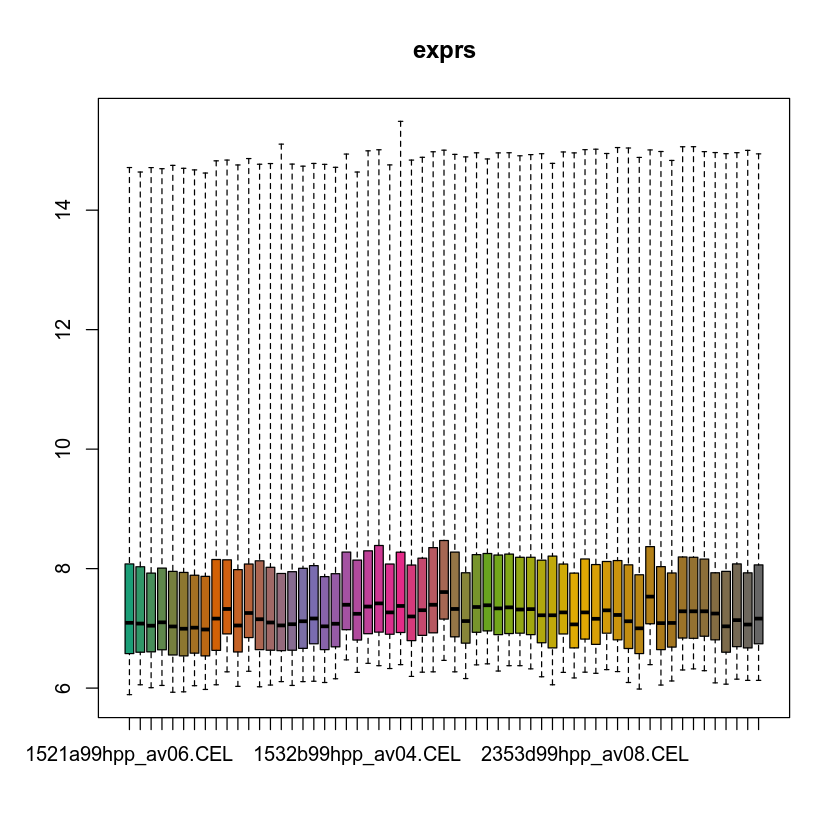

In [11]:
# Boxplot экспрессии генов
# График показывает среднее и первый и третий квартили
# A также разброс данных по каждому файлу
boxplot(affyExpressionFS)

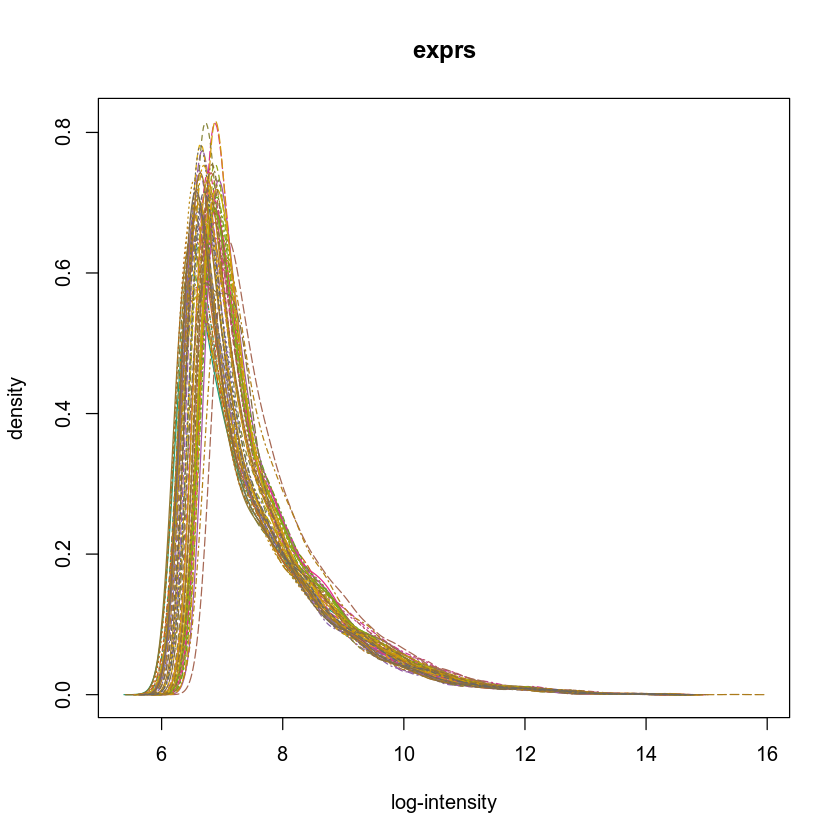

In [12]:
# Гистограмма экспрессии генов
# График показывает распределение экспрессии генов
# по каждому файлу 
# В хороших данных 
hist(affyExpressionFS)

## Background correction

In [13]:
# Выводим все доступные методы background correction
backgroundCorrectionMethods()

[1] "rma"  "mas"  "LESN"

### RMA

* MM can detect true signal for some probes(but others seem to represent “background”)
* Difference of PM from “background” increases with concentration - (in spike-in)
* Probe effects exist
* The  RMA  algorithm  can  be  applied  to  the  raw  data  of  expression  arrays.

Background correcting... 
OK



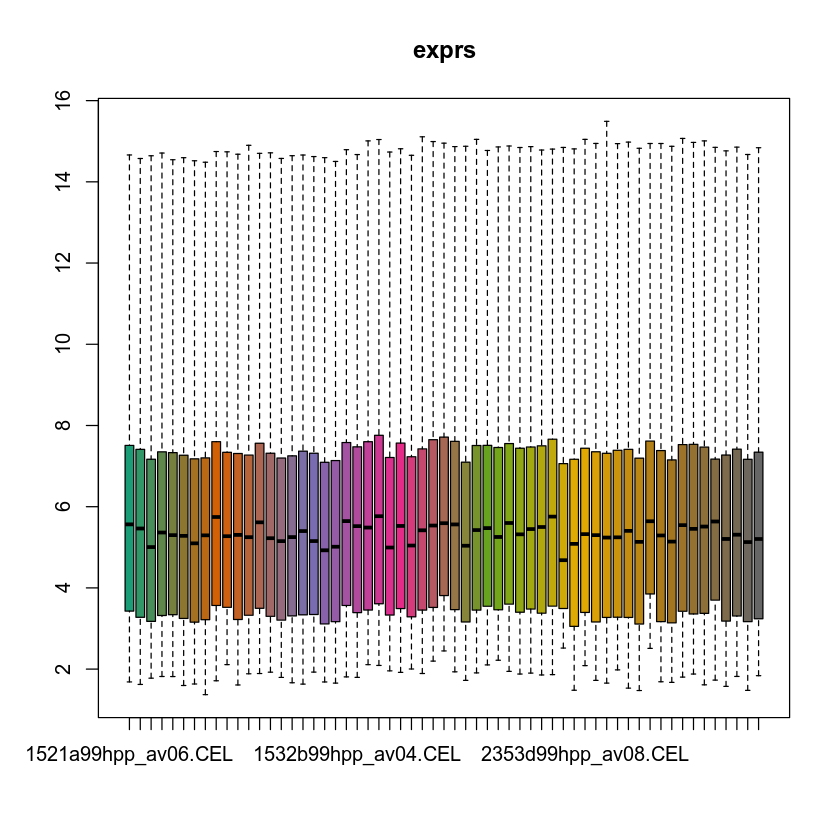

In [14]:
rma_affy <- backgroundCorrect(affyExpressionFS, method='rma')
boxplot(rma_affy)

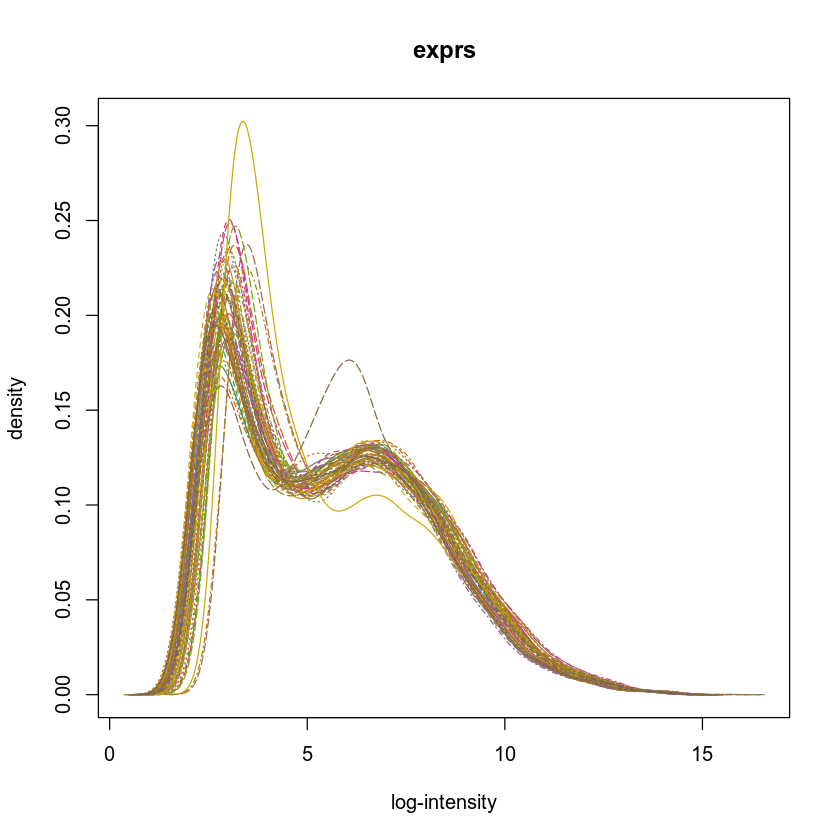

In [15]:
hist(rma_affy)

### MAS5

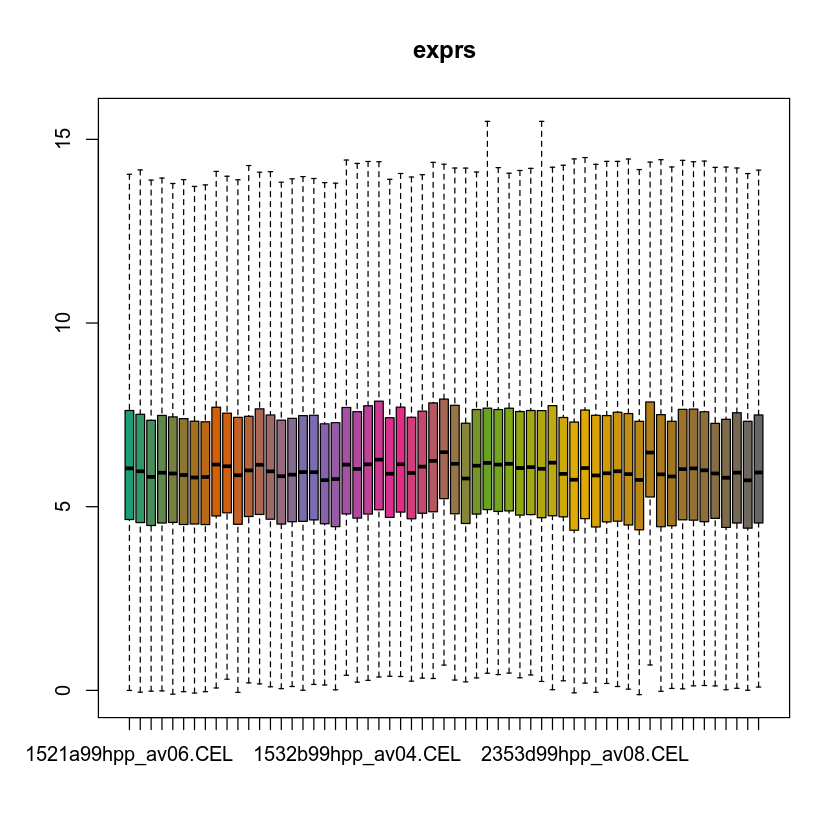

In [16]:
mas_affy <- backgroundCorrect(affyExpressionFS, method='mas') 
boxplot(mas_affy)

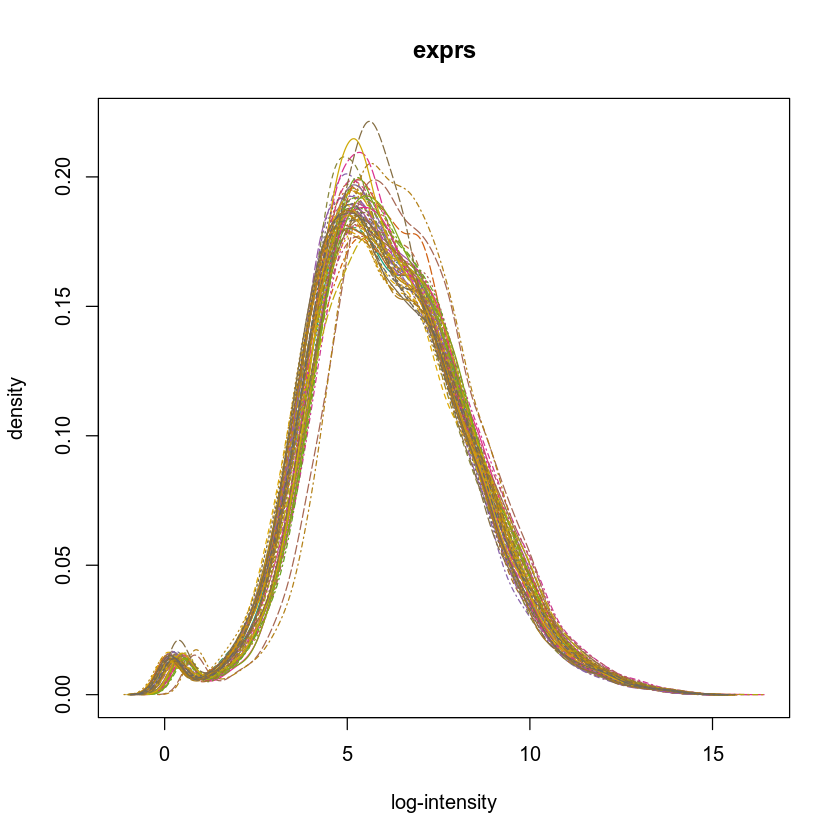

In [17]:
# Видно, что алгоритм не очень хорошо справился с задачей
hist(mas_affy)

## Normalization

In [18]:
# Выводим все методы нормализации
# Но мы рассмотрим quantile
oligo::normalizationMethods()

[1] "quantile"           "quantile.robust"    "quantile.in.blocks"
[4] "qspline"            "loess"              "invariantset"      
[7] "constant"

In [19]:
norm.affy <- oligo::normalize(rma_affy)
norm.mas <- oligo::normalize(mas_affy)

Normalizing... 
OK

Normalizing... 
OK



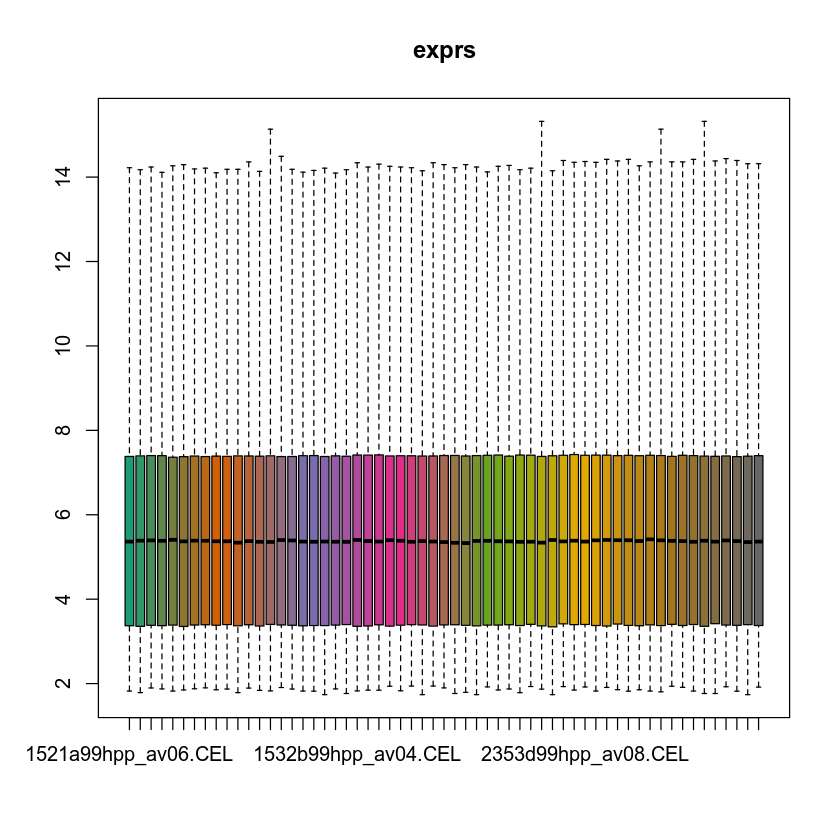

In [20]:
# Мы можем заметить, что среднее всех файлов стало примерно одинаковым
boxplot(norm.affy)

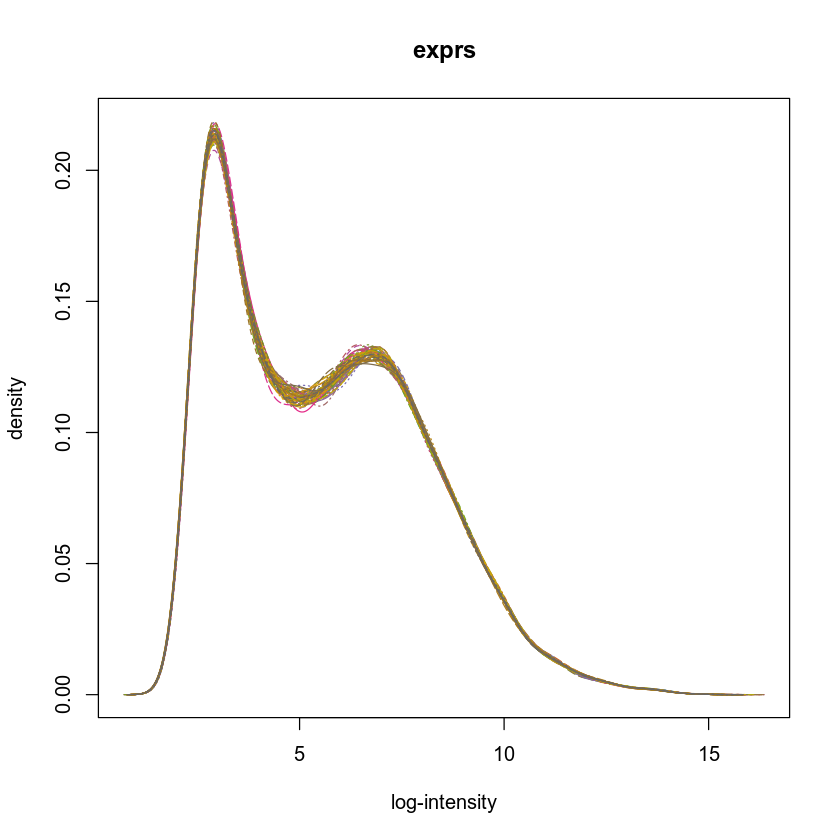

In [21]:
# Получилось более выраженное двух горбовое распределение
# Тем более сейчас не видно выбросов
hist(norm.affy)

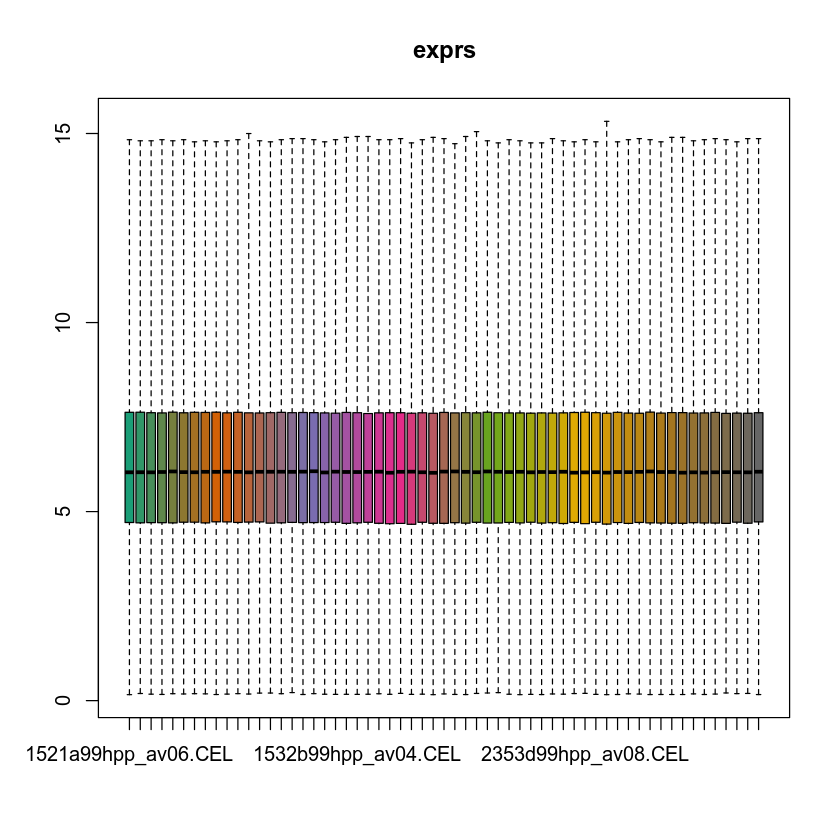

In [23]:
# Мы можем заметить, что среднее всех файлов стало примерно одинаковым
boxplot(norm.mas)

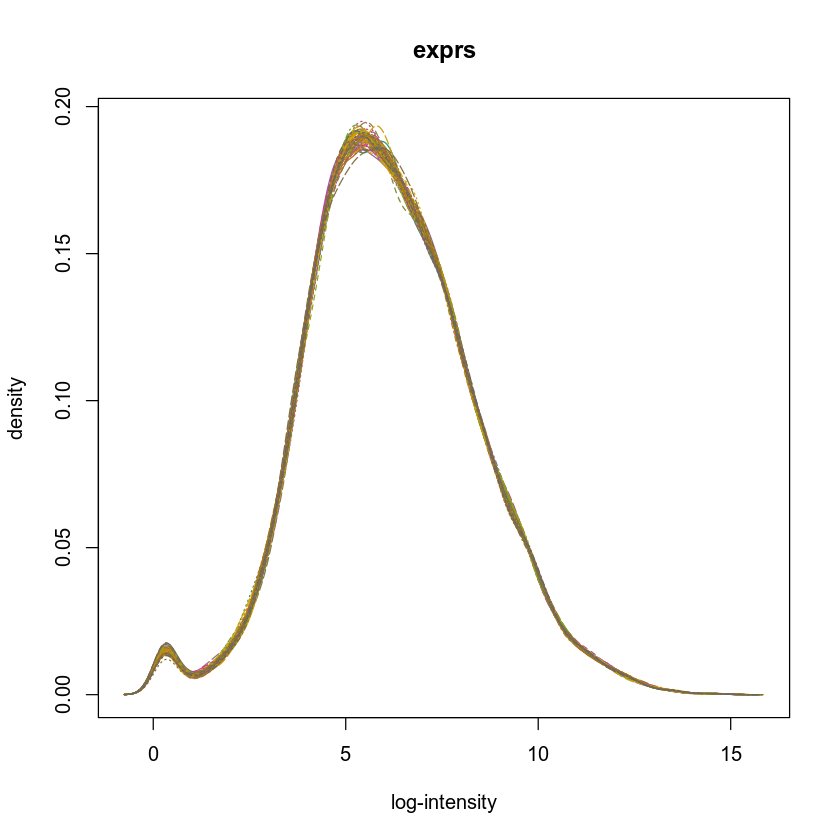

In [25]:
# Получилось более выраженное двух горбовое распределение, хотя все равно выглядит плохо
hist(norm.mas)

### Полная нормализация rma

In [2]:
rma.data <- rma(affyExpressionFS)

Loading required package: RSQLite

Loading required package: DBI



Background correcting
Normalizing
Calculating Expression


In [5]:
head(exprs(rma.data))

,1521a99hpp_av06.CEL,1521b99hpp_av06.CEL,1521c99hpp_av06.CEL,1521d99hpp_av06.CEL,1521e99hpp_av06.CEL,1521f99hpp_av06.CEL,1521g99hpp_av06.CEL,1521h99hpp_av06.CEL,1521i99hpp_av06.CEL,1521j99hpp_av06.CEL,⋯,2353k99hpp_av08.CEL,2353l99hpp_av08.CEL,2353m99hpp_av08.CEL,2353n99hpp_av08.CEL,2353o99hpp_av08.CEL,2353p99hpp_av08.CEL,2353q99hpp_av08.CEL,2353r99hpp_av08.CEL,2353s99hpp_av08.CEL,2353t99hpp_av08.CEL
100_g_at,7.568887,7.440639,7.705738,7.526059,7.571148,7.538158,7.489442,7.434164,7.533631,7.471385,⋯,7.397656,7.382764,7.433718,7.482797,7.474292,7.336264,7.355880,7.443960,7.486639,7.448057
1000_at,6.304986,6.123832,6.382622,6.401523,6.363527,6.193510,6.205858,6.125079,6.297398,6.232895,⋯,6.194012,6.263804,6.178159,6.222149,6.140877,5.880983,6.256199,6.172586,6.178713,6.221019
1001_at,4.558553,4.501663,4.934192,4.779352,4.777787,4.816449,4.904279,4.704325,4.755935,4.998034,⋯,4.628096,4.694271,4.720613,4.810894,4.579886,4.127977,4.642788,4.848766,4.761282,4.903606
1002_f_at,5.029983,5.015750,5.118924,5.020912,5.072810,4.999057,5.001571,4.863347,5.140791,4.928946,⋯,5.106828,5.045907,5.019149,5.265898,5.106881,4.629212,4.886909,4.997839,4.967598,4.997597
1003_s_at,6.671526,6.720981,6.783565,6.673280,6.713719,6.782763,6.677064,6.682233,6.723024,6.707596,⋯,6.664840,6.681288,6.748977,6.809120,6.780471,6.345550,6.570432,6.670584,6.782889,6.722630
1004_at,6.170939,6.111405,6.374159,6.264937,6.310468,6.358731,6.271370,6.006208,6.327925,6.132489,⋯,6.032456,5.995789,6.028294,6.125068,6.147020,5.696462,5.882923,6.085685,6.087837,6.020928


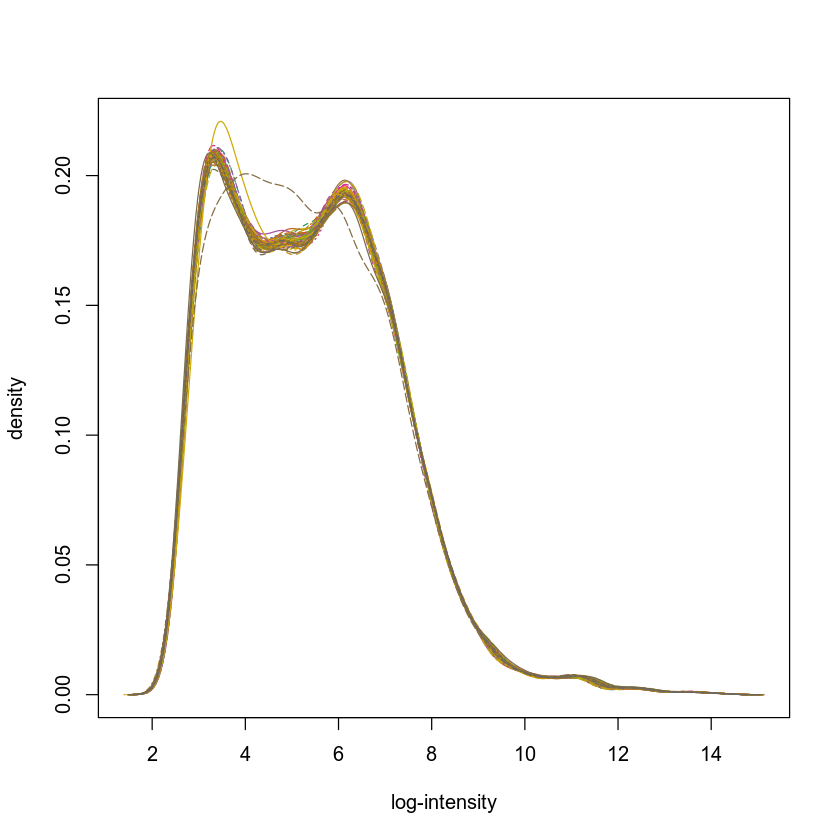

In [3]:
hist(rma.data)

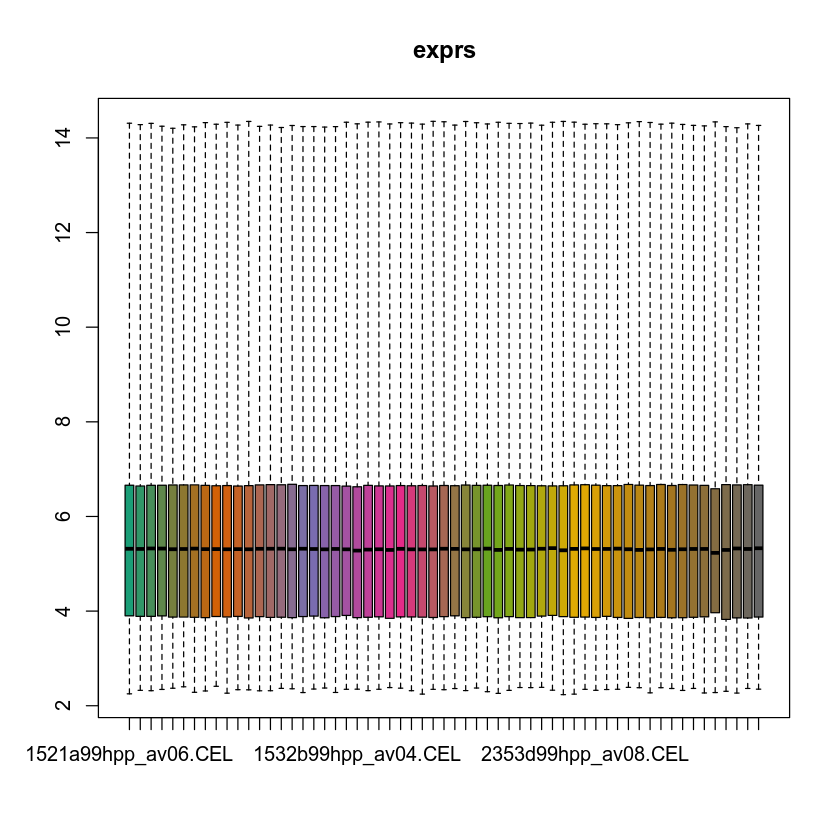

In [4]:
boxplot(rma.data)